In [1]:
from pathlib import Path
import json
from tqdm import tqdm
import subprocess
import sys

import numpy as np
import matplotlib.pyplot as plt

from kliff import nn
from kliff.calculators import CalculatorTorch
from kliff.dataset import Dataset
from kliff.dataset.weight import Weight
from kliff.descriptors import SymmetryFunction
from kliff.models import NeuralNetwork

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
PART_DIR = ROOT_DIR / f"{partition}_partition_data"
FP_DIR = PART_DIR / "fingerprints"
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [5]:
##########################################################################################
# Model
# -----

# Architecture
Nlayers = 4  # Number of layers, excluding input layer, including outpt layer
Nnodes = 128  # Number of nodes per hidden layer
dropout_ratio = 0.0  # Don't use dropout

# Descriptor
descriptor = SymmetryFunction(
    cut_name="cos", cut_dists={"C-C": 5.0}, hyperparams="set51", normalize=True
)
model = NeuralNetwork(descriptor)

# Layers
hidden_layer_mappings = []
for _ in range(Nlayers - 2):
    hidden_layer_mappings.append(nn.Dropout(dropout_ratio))
    hidden_layer_mappings.append(nn.Linear(Nnodes, Nnodes))
    hidden_layer_mappings.append(nn.Tanh())

model.add_layers(
    # input layer
    nn.Linear(descriptor.get_size(), Nnodes),  # Mapping from input layer to the first
    nn.Tanh(),  # hidden layer
    # hidden layer(s)
    *hidden_layer_mappings,  # Mappings between hidden layers in the middle
    # hidden layer(s)
    nn.Dropout(dropout_ratio),  # Mapping from the last hidden layer to the output layer
    nn.Linear(Nnodes, 1),
    # output layer
)

# Load best model
model.load(PART_DIR / "model_best_train.pkl")

# training set
dataset_path = PART_DIR / "carbon_training_set"
weight = Weight(energy_weight=1.0, forces_weight=np.sqrt(0.1))
tset = Dataset(dataset_path, weight)
configs = tset.get_configs()
nconfigs = len(configs)

# calculator
gpu = False
calc = CalculatorTorch(model, gpu=gpu)
_ = calc.create(
    configs,
    nprocs=20,
    reuse=True,
    fingerprints_filename=FP_DIR / f"fingerprints_train.pkl",
    fingerprints_mean_stdev_filename=FP_DIR / f"fingerprints_train_mean_and_stdev.pkl",
)
bestfit_params = calc.get_opt_params()

2024-01-10 10:44:41.330 | INFO     | kliff.models.model_torch:load:117 - Model loaded from `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/yonatan_partition_data/model_best_train.pkl`
2024-01-10 10:44:51.029 | INFO     | kliff.dataset.dataset:_read:398 - 4309 configurations read from /data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/yonatan_partition_data/carbon_training_set
2024-01-10 10:44:51.040 | INFO     | kliff.calculators.calculator_torch:_get_device:592 - Training on cpu
2024-01-10 10:44:51.045 | INFO     | kliff.calculators.calculator_torch:create:93 - Reuse fingerprints `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/yonatan_partition_data/fingerprints/fingerprints_train.pkl`
2024-01-10 10:44:51.048 | INFO     | kliff.calculators.calculator_torch:create:111 - Reuse fingerprints mean and stdev `/data/yonatan/myproject/scripts/compare_UQ/neuralnetwork/C/yonatan_partition_data/fingerprints/fingerprints_train_mean_and_stdev.pkl`


In [6]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    ROOT_DIR
    / "training_dropout"
    / "results"
    / "dropout"
    / f"{partition}_partition"
    / "uncertainty_energy_vs_latconst.npz"
)
alist = dropout_data["alist"]
energy_mean_do = dropout_data["energy_mean"]
energy_error_do = dropout_data["energy_error"]

In [7]:
##########################################################################################
# FIM
# ---
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    preds_samples = preds_data["energy_ensembles"]
else:
    preds_samples = np.empty((0, len(alist)))
    for ii in tqdm(range(100)):
        # Predictions
        modelname = f"DUNN_C_fimbayes_{ii:03d}"
        _, eng, _ = energyvslatconst(modelname, alist, apply_dropout=False)
        preds_samples = np.row_stack((preds_samples, eng))
    preds_samples = preds_samples.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=preds_samples)

In [8]:
mean_samples_target = np.mean(preds_samples, axis=0)
err_samples_target = np.std(preds_samples, axis=0)

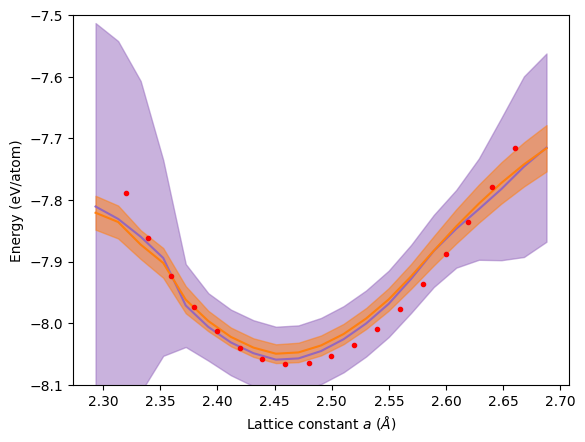

In [9]:
# Plot
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")
# FIM
plt.fill_between(
    alist,
    mean_samples_target + err_samples_target,
    mean_samples_target - err_samples_target,
    alpha=0.5,
    color="tab:purple",
)
plt.plot(alist, mean_samples_target, color="tab:purple", label="DUNN FIM")

# Dropout
plt.fill_between(
    alist,
    energy_mean_do + energy_error_do,
    energy_mean_do - energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, color="tab:orange", label="DUNN dropout")

plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()